## 1. knowing the data 

### 1.1 Loading the data from Kaggle

In [1]:

import pandas as pd 

df = pd.read_csv("train.csv") 

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 1.2 Balanced or Imbalanced data?

Text(0.5, 1.0, 'Number of disaster tweets and non disaster tweets')

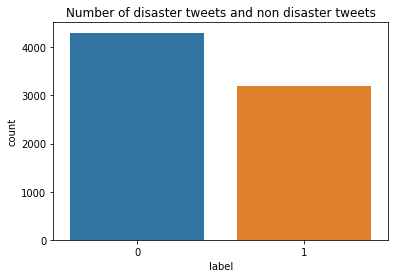

In [375]:
import seaborn as sns
sns.countplot(df.target)
plt.xlabel('label')
plt.title('Number of disaster tweets and non disaster tweets')

Therefore, the data are balanced because the difference between the number of members of these two classes is not large!


## 2. Data Preprocessing

### 2.1 Handle Possible Duplicates

In [7]:
df = df.drop([ 'id', 'keyword', 'location'], axis=1)

In [8]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df['text'].describe(include='all')

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [10]:
df.drop_duplicates(['text'], inplace=True)


In [11]:
df['text'].describe(include='all')

count                                                  7503
unique                                                 7503
top       Large sinkhole swallows entire pond in Lowndes...
freq                                                      1
Name: text, dtype: object

According to the codes above, 110 duplicate texts are deleted from the df.

In [12]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### 2.2 Drop NaN

In [13]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 2 columns):
text      7503 non-null object
target    7503 non-null int64
dtypes: int64(1), object(1)
memory usage: 175.9+ KB


we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

### 2.3. Remove HTML Marks

Via the first regex, <[^>]*>, in the preceding code section, we tried to remove all of the HTML markup from the movie reviews. Although many programmers generally advise
against the use of regex to parse HTML, this regex should be sufficient to clean this particular dataset. Since we are only interested in removing HTML markup and do not plan to use the HTML markup further, using regex to do the job should be acceptable (Raschka and Mirjalili, 2, 3rd edition). 

In [14]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text


### 2.4. Remove Stop Words

In [15]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [16]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [17]:
print(len(STOP_WORDS))

326


In [18]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [19]:
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarakhanjani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
#at first, I made a list of text coulumn but the error for the next cell--Tokenizer-- was:
# list of values of 'text' column 
#text1 = df['text'].tolist() 
  
# show the list 
#print(text1)

In [21]:
from nltk.corpus import stopwords

In [22]:
stop = stopwords.words('english')
print(len(stop))

179


In [23]:
import string

punctuations = string.punctuation

print(len(punctuations))

32


In [24]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['tweet_without_stopwords'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))
print(df)

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7604  #WorldNews Fallen powerlines on G:link tram: U...       1   
7605  on the flip side I'm at Walmart and there is a...       1   
7606  Suicide bomber kills 15 in Saudi security site...       1   
7608  Two giant cranes holding a bridge collapse int...       1   
7612  The Latest: More Homes Razed by Northern Calif...       1   

                                tweet_without_stopwords  
0        Our Deeds Reason #earthquake May ALLAH Forgive  
1                Forest fire near La Ronge Sask. Canada  
2     All residents a

In [25]:
shape = df.shape
print(shape)

(7503, 3)


#### NOTE: Removing Stop words or using TFIDF?!


From the way the TfIdf score is set up, there shouldn't be any significant difference in removing the stopwords. The whole point of the Idf is exactly to remove words with no semantic value from the corpus. If you do add the stopwords, the Idf should get rid of it. However, working without the stopwords in your documents will make the number of features smaller, which might have a slight computational advantage. Removing stop-words is a useful technique to preprocess texts when we are working with raw or normalized term frequencies and not tf-idfs, which down weight frequently occurring words (Raschka and Mirjalili, 2, 3rd edition). 


### 2.5. Vectorization and stemming

In [26]:
# using tfidf with not deleting stop words
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
print(vectorizer.get_feature_names())

['00', '000', '0000', '007npen6lg', '00cy9vxeff', '00end', '00pm', '01', '02', '0215', '02elqlopfk', '02pm', '03', '030', '033', '034', '039', '03l7nwqdje', '04', '05', '05th', '06', '060', '061', '06jst', '07', '073izwx0lb', '08', '0840728', '0853', '087809233445', '0880', '08lngclzsj', '09', '0abgfglh7x', '0ajisa5531', '0blkwcupzq', '0btniwagt1', '0bvk5tub4j', '0c1y8g7e9p', '0cr74m1uxm', '0cxm5tkz8y', '0dqjeretxu', '0drqlrsgy5', '0dxvz7fdh3', '0erisq25kt', '0f8xa4ih1u', '0fekgyby5f', '0fs9ksv5xk', '0ghk693egj', '0gidg9u45j', '0gknpy4lua', '0h7oua1pns', '0iw6drf5x9', '0iyuntxduv', '0jfnvaxfph', '0jmkdtcymj', '0kccg1bt06', '0keh2treny', '0krw1zyahm', '0l', '0la1aw9uud', '0llwuqn8vg', '0lmheaex9k', '0lpu0gr2j0', '0m1tw3datd', '0mcxc68gzd', '0migwcmtje', '0mnpcer9no', '0npzp', '0nr4dpjgyl', '0oms8ri3l1', '0pamznyyuw', '0q040stkcv', '0r03c6njli', '0rny349unt', '0rokdutyun', '0rsverlztm', '0s6ydfrwdq', '0sa6xx1oq7', '0scnwe8xbv', '0szwlwl9qu', '0t8vqkeari', '0t9yd557ry', '0tslqjokvh', '0tz

In [28]:
X.shape

(7503, 21637)

In [29]:
# using tfidf AFTER deleting stop words
vectorizer = TfidfVectorizer()
X2 = vectorizer.fit_transform(df['tweet_without_stopwords'])
print(vectorizer.get_feature_names())

['00', '000', '0000', '007npen6lg', '00cy9vxeff', '00end', '00pm', '01', '02', '0215', '02elqlopfk', '02pm', '03', '030', '033', '034', '039', '03l7nwqdje', '04', '05', '05th', '06', '060', '061', '06jst', '07', '073izwx0lb', '08', '0840728', '0853', '087809233445', '0880', '08lngclzsj', '09', '0abgfglh7x', '0ajisa5531', '0blkwcupzq', '0btniwagt1', '0bvk5tub4j', '0c1y8g7e9p', '0cr74m1uxm', '0cxm5tkz8y', '0dqjeretxu', '0drqlrsgy5', '0dxvz7fdh3', '0erisq25kt', '0f8xa4ih1u', '0fekgyby5f', '0fs9ksv5xk', '0ghk693egj', '0gidg9u45j', '0gknpy4lua', '0h7oua1pns', '0iw6drf5x9', '0iyuntxduv', '0jfnvaxfph', '0jmkdtcymj', '0kccg1bt06', '0keh2treny', '0krw1zyahm', '0l', '0la1aw9uud', '0llwuqn8vg', '0lmheaex9k', '0lpu0gr2j0', '0m1tw3datd', '0mcxc68gzd', '0migwcmtje', '0mnpcer9no', '0npzp', '0nr4dpjgyl', '0oms8ri3l1', '0pamznyyuw', '0q040stkcv', '0r03c6njli', '0rny349unt', '0rokdutyun', '0rsverlztm', '0s6ydfrwdq', '0sa6xx1oq7', '0scnwe8xbv', '0szwlwl9qu', '0t8vqkeari', '0t9yd557ry', '0tslqjokvh', '0tz

In [30]:
X2.shape

(7503, 21616)

As you can see there is not a necessary need to remove stop words when using tfifd approach. However, not removing stop words made a little  bit bigger feature matrix!

#### 2.5.1. stemming
I want to use stemming after removing stop words and before vectorization. 
NOTE: While stemming can create non-real words, such as 'thu' (from 'thus'), as shown in the previous example, a technique called lemmatization aims to obtain the canonical (grammatically correct) forms of individual words—the so-called lemmas. However, lemmatization is computationally more difficult and expensive compared to stemming and, in practice, it has been observed that stemming and lemmatization have little impact on the performance of text classification (Influence of Word Normalization on Text Classification, Michal Toman, Roman Tesar, and Karel Jezek, Proceedings of InSciT, pages 354–358, 2006).


In [135]:
from nltk.stem import PorterStemmer
ps=PorterStemmer()
dir(ps)

['MARTIN_EXTENSIONS',
 'NLTK_EXTENSIONS',
 'ORIGINAL_ALGORITHM',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_abc_impl',
 '_apply_rule_list',
 '_contains_vowel',
 '_ends_cvc',
 '_ends_double_consonant',
 '_has_positive_measure',
 '_is_consonant',
 '_measure',
 '_replace_suffix',
 '_step1a',
 '_step1b',
 '_step1c',
 '_step2',
 '_step3',
 '_step4',
 '_step5a',
 '_step5b',
 'mode',
 'pool',
 'stem',
 'unicode_repr',
 'vowels']

In [175]:
def Convert(string): 
    li = list(string.split(" ")) 
    return li 

In [176]:
df['weet_without_stopwords_duplicated_list']=df['tweet_without_stopwords_duplicated'].apply(lambda x: Convert(x))

In [178]:
def stemming(tokenized_text):
    text=[ps.stem(word) for word in tokenized_text]
    return text

In [179]:
df['text_stemed']=df['weet_without_stopwords_duplicated_list'].apply(lambda x: stemming(x))

In [180]:
df.head()

,text,target,tweet_without_stopwords,text_stemed,tweet_without_stopwords_duplicated,len_text,weet_without_stopwords_duplicated_list
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason #earthquake May ALLAH Forgive,"[our, deed, reason, #earthquak, may, allah, fo...",Our Deeds Reason #earthquake May ALLAH Forgive,46,"[Our, Deeds, Reason, #earthquake, May, ALLAH, ..."
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, La, rong, sask., canada]",Forest fire near La Ronge Sask. Canada,38,"[Forest, fire, near, La, Ronge, Sask., Canada]"
2,All residents asked to 'shelter in place' are ...,1,All residents asked 'shelter place' notified o...,"[all, resid, ask, 'shelter, place', notifi, of...",All residents asked 'shelter place' notified o...,98,"[All, residents, asked, 'shelter, place', noti..."
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","[13,000, peopl, receiv, #wildfir, evacu, order...","13,000 people receive #wildfires evacuation or...",61,"[13,000, people, receive, #wildfires, evacuati..."
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby #Alaska smoke #wildfi...,"[just, got, sent, photo, rubi, #alaska, smoke,...",Just got sent photo Ruby #Alaska smoke #wildfi...,62,"[Just, got, sent, photo, Ruby, #Alaska, smoke,..."


In [182]:
df['text_stemed_prepared'] = df['text_stemed'].apply(lambda x: ', '.join(map(str, x)))

In [183]:
df.head()

,text,target,tweet_without_stopwords,text_stemed,tweet_without_stopwords_duplicated,len_text,weet_without_stopwords_duplicated_list,text_stemed_prepared
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason #earthquake May ALLAH Forgive,"[our, deed, reason, #earthquak, may, allah, fo...",Our Deeds Reason #earthquake May ALLAH Forgive,46,"[Our, Deeds, Reason, #earthquake, May, ALLAH, ...","our, deed, reason, #earthquak, may, allah, forgiv"
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, La, rong, sask., canada]",Forest fire near La Ronge Sask. Canada,38,"[Forest, fire, near, La, Ronge, Sask., Canada]","forest, fire, near, La, rong, sask., canada"
2,All residents asked to 'shelter in place' are ...,1,All residents asked 'shelter place' notified o...,"[all, resid, ask, 'shelter, place', notifi, of...",All residents asked 'shelter place' notified o...,98,"[All, residents, asked, 'shelter, place', noti...","all, resid, ask, 'shelter, place', notifi, off..."
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","[13,000, peopl, receiv, #wildfir, evacu, order...","13,000 people receive #wildfires evacuation or...",61,"[13,000, people, receive, #wildfires, evacuati...","13,000, peopl, receiv, #wildfir, evacu, order,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby #Alaska smoke #wildfi...,"[just, got, sent, photo, rubi, #alaska, smoke,...",Just got sent photo Ruby #Alaska smoke #wildfi...,62,"[Just, got, sent, photo, Ruby, #Alaska, smoke,...","just, got, sent, photo, rubi, #alaska, smoke, ..."


In [187]:
# using tfidf AFTER deleting stop words and stemming
vectorizer = TfidfVectorizer()
X3 = vectorizer.fit_transform(df['text_stemed_prepared'])
print(vectorizer.get_feature_names())

['00', '000', '0000', '007npen6lg', '00cy9vxeff', '00end', '00pm', '01', '02', '0215', '02elqlopfk', '02pm', '03', '030', '033', '034', '039', '03l7nwqdj', '04', '05', '05th', '06', '060', '061', '06jst', '07', '073izwx0lb', '08', '0840728', '0853', '087809233445', '0880', '08lngclzsj', '09', '0abgfglh7x', '0ajisa5531', '0blkwcupzq', '0btniwagt1', '0bvk5tub4j', '0c1y8g7e9p', '0cr74m1uxm', '0cxm5tkz8i', '0dqjeretxu', '0drqlrsgy5', '0dxvz7fdh3', '0erisq25kt', '0f8xa4ih1u', '0fekgyby5f', '0fs9ksv5xk', '0ghk693egj', '0gidg9u45j', '0gknpy4lua', '0h7oua1pn', '0iw6drf5x9', '0iyuntxduv', '0jfnvaxfph', '0jmkdtcymj', '0kccg1bt06', '0keh2treni', '0krw1zyahm', '0l', '0la1aw9uud', '0llwuqn8vg', '0lmheaex9k', '0lpu0gr2j0', '0m1tw3datd', '0mcxc68gzd', '0migwcmtj', '0mnpcer9no', '0npzp', '0nr4dpjgyl', '0oms8ri3l1', '0pamznyyuw', '0q040stkcv', '0r03c6njli', '0rny349unt', '0rokdutyun', '0rsverlztm', '0s6ydfrwdq', '0sa6xx1oq7', '0scnwe8xbv', '0szwlwl9qu', '0t8vqkeari', '0t9yd557ri', '0tslqjokvh', '0tzsqe

In [188]:
X3.shape

(7503, 19955)

In [189]:
from sklearn.feature_extraction.text import CountVectorizer
cv1=CountVectorizer()
X4= cv1. fit_transform(df["text_stemed_prepared"])


In [190]:
X4.shape

(7503, 19955)

In [31]:
y = df['target']

### 2.6. Spliting data into test and train subsets

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X2, y, test_size=0.3, random_state=0)
X_train.shape, y_train.shape


((5252, 21616), (5252,))

In [41]:
X_test.shape, y_test.shape

((2251, 21616), (2251,))

### 2.7. feature reduction using PCA

The Python toolkit scikit-learn has a few PCA variants, of which RandomizedPCA can handle sparse matrices.

In [51]:
import numpy  as np
from sklearn.decomposition import PCA as RandomizedPCA
#now we need to find the optimized n_components
# I can use RandomizedPCA easily with choosing n_components by chance or with no reason! However, I want to model the
#data using the most possible information. Therefore, I prefered to apply PCA from scratch
#and gain eaigen values and eaigen vectors!


In [57]:
#since X_train is a scipy matrix  we change its type
#to numpy array to be able to find the covariance matrix
#that is needed to find eaigen vectors and values!
X_train_array = X_train.toarray()
cov_mat = np.cov(X_train_array.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
#print('\nEigenvalues \n%s' % eigen_vals)

In [125]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# var_exp is a list with the length of 21616! we just need to see the largest elemnts of this list that means words 
#that contain the most variance 
# Python program to find N largest 
# element from given list of integers   
# Function returns N largest elements 
def Nmaxelements(var_exp, N): 
    final_list = [] 
  
    for i in range(0, N):  
        max1 = 0
          
        for j in range(len(var_exp)):      
            if var_exp[j] > max1: 
                max1 = var_exp[j]; 
                  
        var_exp.remove(max1); 
        final_list.append(max1) 
          
    print(final_list) 
    N = 2000
    
    return (final_list)   
var_exp_max = Nmaxelements(var_exp, 2000)




[(0.0050786865675325815+0j), (0.0036978943566285537+0j), (0.003403960821199124+0j), (0.0031665654143709717+0j), (0.0029942227431168835+0j), (0.0026707147977943903+0j), (0.0024331105132572558+0j), (0.0024128550516030307+0j), (0.002325276919894467+0j), (0.0022664275801388143+0j), (0.0022118731961944184+0j), (0.002180907606485046+0j), (0.0020874512059378394+0j), (0.002070318969256757+0j), (0.002032346358095793+0j), (0.0019926275285604257+0j), (0.0019475330964374437+0j), (0.0019276313728753376+0j), (0.0019076171298906025+0j), (0.0018782390746825634+0j), (0.0018623993142163353+0j), (0.0018169703518201303+0j), (0.0018017859602935187+0j), (0.0017670181108269567+0j), (0.001711744564206982+0j), (0.0017026494363601363+0j), (0.0016811873038879753+0j), (0.0016345584463916237+0j), (0.0015679835314520228+0j), (0.001549961328019787+0j), (0.0015278576722578885+0j), (0.0015127063991360625+0j), (0.001501749427953617+0j), (0.0014869292943083573+0j), (0.0014761612974524205+0j), (0.0014634434165293885+0j),

In [126]:
cum_var_exp_max = np.cumsum(var_exp_max)


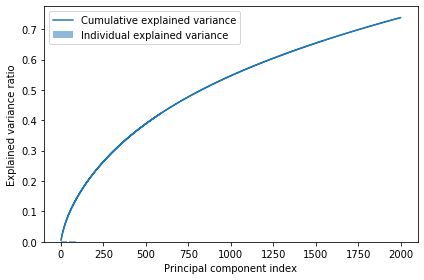

In [127]:
import matplotlib.pyplot as plt
plt.bar(range(1,2001), var_exp_max, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,2001), cum_var_exp_max, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
 

with 2000 principal components we can cover 70% of the variance in our data set! Now when we have suitable number of principal components, we can apply PCA using sklearn PCA. 
According to https://stats.stackexchange.com/questions/55718/pca-and-the-train-test-split
For measuring the generalization error, you need to do the latter: a separate PCA for every training set (which would mean doing a separate PCA for every classifier and for every CV fold).

## 3. Modeling and Evaluation
as noted in the comments sparse input for RandomizedPCA is deprecated: instead you should use sklearn.decomposition.TruncatedSVD that does precisely what RandomizedPCA used to do on sparse data but should not have been called PCA in the first place.

To clarify: PCA is mathematically defined as centering the data (removing the mean value to each feature) and then applying truncated SVD on the centered data.

As centering the data would destroy the sparsity and force a dense representation that often does not fit in memory any more, it is common to directly do truncated SVD on sparse data (without centering). This resembles PCA but it's not exactly the same. This is implemented in scikit-learn as sklearn.decomposition.TruncatedSVD.

In [192]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
# dimensionality reduction:
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)



In [194]:
X_train_svd.shape

(5252, 2000)

In [196]:
X_test_svd.shape

(2251, 2000)

### 3.1. Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression



# logistic regression estimator:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
#fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_svd, y_train)


In [211]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train_svd, y_train, cv=5)
scores


array([0.76688868, 0.78211227, 0.80380952, 0.79619048, 0.80380952])

In [212]:
scores = cross_val_score(lr, X_test_svd, y_test, cv=5)
scores

array([0.73614191, 0.72222222, 0.74      , 0.77111111, 0.75555556])

### 3.2. Random Forest

In [215]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train_svd, y_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [216]:
scores_rf = cross_val_score(rf, X_train_svd, y_train, cv=5)
scores_rf

array([0.73263559, 0.73644148, 0.74571429, 0.73238095, 0.74285714])

In [ ]:
scores_rf = cross_val_score(rf, X_test_svd, y_test, cv=5)
scores_rf

### 3.3. Neural Net MLP
The Parameters are selected using trial and error

In [247]:
from sklearn.neural_network import MLPClassifier

In [310]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 20), random_state=1, max_iter=1000, activation= 'relu', alpha=0.0001, batch_size= 200, learning_rate= 'invscaling', early_stopping= True).fit(X_train_svd, y_train)
mlp.predict(X_test_svd)
mlp.score(X_train_svd, y_train)

0.8958492003046459

In [311]:
mlp.score(X_test_svd, y_test)

0.7925366503776099

In [312]:
scores_mlp = cross_val_score(mlp, X_train_svd, y_train, cv=5)
scores_mlp

array([0.7583254 , 0.76879163, 0.7847619 , 0.79142857, 0.7752381 ])

In [308]:
scores_mlp = cross_val_score(mlp, X_test_svd, y_test, cv=5)
scores_mlp

array([0.75831486, 0.77777778, 0.71333333, 0.76888889, 0.73555556])

### 3.4. Using RNN (LSTM) for text classification

In [354]:

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [366]:
max_features = 2000  # Only consider the top 2000 words (actually all unique words after applying PCA)
maxlen = 500  # Only consider the first 500 words of each movie review

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    # Embed each integer in a 128-dimensional vector
    #x = layers.Embedding(max_features, embedding_dim)(inputs)
    layer = Embedding(max_words,128,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64, return_sequences=True))(layer)
    layer = Bidirectional(LSTM(64))(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [367]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 2000)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 2000, 128)         64000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 2000, 128)         98816     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129       
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0   

In [371]:
model.fit(X_train_svd,  y_train,batch_size=200,epochs=10,
          validation_split=0.0016, callbacks=[EarlyStopping(monitor='accuracy',min_delta=0.1)])

Train on 5243 samples, validate on 9 samples
Epoch 1/10
5243/5243 [==============================] - 628s 120ms/step - loss: 0.6842 - accuracy: 0.5710 - val_loss: 0.6466 - val_accuracy: 0.6667
Epoch 2/10
5243/5243 [==============================] - 578s 110ms/step - loss: 0.6842 - accuracy: 0.5712 - val_loss: 0.6399 - val_accuracy: 0.6667
